## Dependencies

`pip install [modules]`
* jupyter
* pandas
  * numexpr (optional, speedup)
  * bottleneck (optional, speedup)

*PostgreSQL support*
* sqlalchemy
* psycopg2

*Machine learning*
* scikit-learn
* sklearn-pandas
* imbalanced-learn
* networkx

*Only for plotting*
* matplotlib
* seaborn

In [4]:
import sqlalchemy
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

In [3]:
db = sqlalchemy.create_engine('postgresql://localhost/crunchbase')
connection = db.connect()

## Companies

At this section we select the companies we want to work on using the following criteria:

* At least one funding round of any type
* Primary role is *company*
* Established in year 2001 or later — see `START_DATE`
* Really early shut downs and exits are neglected (before 60 days) — see `MIN_DAYS`

The query is somewhat large, we join tables

* `crunchbase_organizations`
* `crunchbase_acquisitions`
* `crunchbase_ipos`
* `crunchbase_funding_rounds`

to get companies along the following fields: `uuid`, `company_name`, `first_funding_round_on`, `last_funding_round_on`, `closed_on`, `acquired_on`, `went_public_on`.

Company status reference: ipo, operating, closed, acquired.

Company primary role reference: investor, company, school, group.

In [366]:
START_DATE = '2001-01-01' # greater or equal than

MIN_DAYS = 60


query = """

SELECT o.uuid, o.company_name, first_funding_round_on, last_funding_round_on, closed_on, acquired_on, went_public_on
FROM crunchbase_organizations AS o

-- if company has been acquired multiple times, just bring the earliest acquisition
LEFT OUTER JOIN (
        SELECT DISTINCT ON (acquiree_uuid) acquiree_uuid, acquired_on
        FROM crunchbase_acquisitions
        ORDER BY acquiree_uuid, acquired_on
) AS a
        ON o.uuid = a.acquiree_uuid

-- if company has multiple public offerings, just bring the earliest IPO
LEFT OUTER JOIN (
        SELECT DISTINCT ON (uuid) uuid, went_public_on
        FROM crunchbase_ipos
        ORDER BY uuid, went_public_on
) AS i
        ON o.uuid = i.uuid

-- keep companies that have at least one funding round
JOIN (
        SELECT
            company_uuid,
            min(announced_on) AS first_funding_round_on,
            max(announced_on) AS last_funding_round_on
        FROM crunchbase_funding_rounds
        GROUP BY company_uuid
) AS f
        ON o.uuid = f.company_uuid

WHERE first_funding_round_on >= '%s' AND primary_role = 'company'
    
""" % START_DATE


orgs = pd.read_sql_query(query, connection,
    parse_dates=['first_funding_round_on', 'last_funding_round_on', 'closed_on', 'acquired_on', 'went_public_on'], coerce_float=False)

orgs.uuid = orgs.uuid.astype('str') # Pandas merge does not work without this
orgs.set_index('uuid', inplace=True)

**About foundations**: `funded_on` and `first_funding_on` dates (from `crunchbase_organizations` table) are unreliable. We take `first_funding_round_on` (joined from `crunchbase_funding_rounds`) as a verisimilar foundation date.

**About status**: The `status` attribute (from `crunchbase_organizations` table) is not neatly filled, so we cannot rely on it; `closed_on`, `acquired_on` (joined from `crunchbase_acquisitions`), `went_public_on` (joined from `crunchbase_ipos`) dates are better indicators of a company's fate.

**Heads up**! There are status changes. Some acquired companies were later closed, others were acquired and went public later; on the other hand some companies that went public in the first place were acquired or closed afterwards... not to speak about companies that closed before having an exit. In order to disambiguate the status, `acquired_on` and `went_public_on` have precedence over `closed_on`, between the former two we choose the lesser date (favoring acquisition in case of tie). Moreover, some companies were acquired and/or went public multiple times, we consider the earlier of these events only.

In [367]:
acquired  = orgs[(orgs.acquired_on <= orgs.went_public_on) | (orgs.acquired_on.notnull() & orgs.went_public_on.isnull() )]
ipoed     = orgs[(orgs.acquired_on >  orgs.went_public_on) | (orgs.acquired_on.isnull()  & orgs.went_public_on.notnull())]
closed    = orgs[orgs.closed_on.notnull() & orgs.acquired_on.isnull() & orgs.went_public_on.isnull()]
operating = orgs[orgs.closed_on.isnull()  & orgs.acquired_on.isnull() & orgs.went_public_on.isnull()]

orgs.loc[acquired.index,  'status'] = 'acquired' 
orgs.loc[ipoed.index,     'status'] = 'ipoed'
orgs.loc[closed.index,    'status'] = 'closed'
orgs.loc[operating.index, 'status'] = 'operating'

# significative dates in the data set
MOST_RECENT_DATA_SET_DATE  = orgs.last_funding_round_on.max()
LEAST_RECENT_DATA_SET_DATE = orgs.last_funding_round_on.min()

orgs.loc[acquired.index,  'status_on'] = acquired.acquired_on
orgs.loc[ipoed.index,     'status_on'] = ipoed.went_public_on
orgs.loc[closed.index,    'status_on'] = closed.closed_on
orgs.loc[operating.index, 'status_on'] = MOST_RECENT_DATA_SET_DATE

orgs.drop(['closed_on', 'acquired_on', 'went_public_on'], axis=1, inplace=True) # no needed anymore

We compute a fundamental feature: days since foundation (`status_on`). We drop those companies with negative days since foundation, which does not make sense.

In [368]:
orgs['status_days'] = (orgs.status_on - orgs.first_funding_round_on).dt.days
orgs = orgs[0 <= orgs.status_days]

orgs.drop('status_on', axis=1, inplace=True) # accomplished its mission

Furthermore, we drop companies that exited or closed **within the first 60 days** of operation. This is discretional, could be more, could not be at all. It seems noisy data because it takes on average 4 to 7 years to make an exit, on the other side, closing right after starting seems not even trying.

In [369]:
orgs = orgs[(orgs.status == 'operating') | (MIN_DAYS <= orgs.status_days)]

## Labels

In [370]:
status_merger = lambda x: 'exited' if x == 'acquired' or x == 'ipoed' else x

orgs['merged_status'] = orgs.status.apply(status_merger)

c = orgs.merged_status.value_counts()
print('Operating %6s' % c.operating)
print('Exited    %6s' % c.exited)
print('Closed    %6s' % c.closed)

Operating  74379
Exited      8971
Closed      2249


**It is known that the success rate of startups is grossly 10%. The data set provides a success rate of 80%. Crunchbase is highly biased to successful companies.**

## Features

**Companies** raise **investments** through **funding rounds**. Companies can invest in other companies and can also make acquisitions as part of their business: this is the scope of **acquisitions** and **investments** set of features.

**Companies**
* ~~categories~~ — planned
* status days — its meaning depends on the status: days operating, days to exit or days to shut down

**Acquisitions**
* #acquisitions
* total expended amount

**Investments**
* #investments
* #venture investments
* total invested amount

**Funding rounds**
* #funding rounds
* #venture funding rounds
* #investments
* **raised amount** — comes in flavors; suppose **seed** funding 1.5M / series **A** 2M / series **B** 1M / series **C** 3M
  * total raised amount = 7.5M (seed + A + B + C)
  * last N raised amounts
    * **n0** = 3M (C)
    * **n1** = 1M (B)
    * **n2** = 2M (A)
  * last N aggregated raised amounts
    * **s0** = 7.5M (seed + A + B + C)
    * **s1** = 4.5M (seed + A + B)
    * **s2** = 3.5M (seed + A)
  * last N highest raised amounts
    * **d0** = 3M (C)
    * **d1** = 2M (A)
    * **d2** = 1.5M (seed)

**Investors**
* #investors

*Aggregated by unique investors for a company* (see notes for an explanation)
* #rounds
* #venture rounds / #rounds
* #companies / #rounds
* #leads / #rounds
* #returns / #rounds
* #losses / #rounds
* invested amount / #rounds
* investor score

### Notes on investor features

Except for **#investors** that is the number of unique investors that invested in a particular company, **all other investor features are calculated independently from company features**, then aggregated and applied as company features.

In example, as an investor feature, **#rounds** is the number of funding rounds that an investor has in his/her career. As a company feature, it is the sum of the number of rounds of all the investors for the considered company. If a company is backed by experienced investors the overall **#rounds** will be higher than if they were newcomers.

Most investor features are averaged by **#rounds**, otherwise big venture capital firms outperform the average investor.

**#returns** and **#losses** are counted from investments, not companies. If an investor made two investments in the same company and that company exited, then two returns were achieved.

The **investor score** is the result of building a network of investors and using the *Katz centrality* measure to measure the relative degree of influence of each investor in the network.

## Complementary data

Emphasis was put on companies to carefully select with which to work. In this section we prepare some data to add features to these companies.

In [209]:
def join(query, data_set):
    df = pd.read_sql_query(query, connection, parse_dates=['on'])

    df.company_uuid = df.company_uuid.astype('str') # Pandas merge does not work without this
    
    # filter by companies we have prepared
    df = pd.DataFrame.merge(data_set, df, left_index=True, right_on='company_uuid', how='inner') 

    df.amount  = df.amount.fillna(0)
    df['days'] = (df.on - df.first_funding_round_on).dt.days # days since foundation
    
    # remove pre-foundation events (faulty data) and post-status events (i.e. post-IPO funding rounds)
    df = df[(0 <= df.days) & (df.days <= df.status_days)]
    
    # drop unnecessary columns: first_funding_round_on, last_funding_round_on, status, merged_status, status_days, on
    df.drop(['first_funding_round_on', 'last_funding_round_on', 'status_days'], axis=1, inplace=True)
    
    return df

#### Acquisitions (made by companies)

In [493]:
companies_acquisitions_query = """

SELECT o.uuid AS company_uuid, a.acquired_on AS on, a.price_usd AS amount
FROM crunchbase_organizations AS o
JOIN crunchbase_acquisitions  AS a
        ON o.uuid = a.acquirer_uuid  

"""

acquisitions = join(companies_acquisitions_query, orgs)

#### Investments (made by companies)

Crunchbase does not tell the invested amount per investor in a funding ound,
it does tell the raised amount (total amount) and number of investors.
The best guess we can do is to suppose that in a funding round all investors
participate under the same conditions, providing capital in equal parts.

In [498]:
companies_investments_query = """

SELECT o.uuid AS company_uuid, f.funding_round_type, f.funding_round_code,
       f.announced_on AS on, f.raised_amount_usd / f.investor_count AS amount 
FROM crunchbase_organizations  AS o
JOIN crunchbase_investments    AS i
        ON o.uuid = i.investor_uuid
JOIN crunchbase_funding_rounds AS f
        ON i.funding_round_uuid = f.funding_round_uuid

"""

investments = join(companies_investments_query, orgs)

#### Funding rounds (investments received by companies)

In [496]:
companies_rounds_query = """

SELECT company_uuid, funding_round_type, funding_round_code,
       announced_on AS on, raised_amount_usd AS amount, investor_count
FROM crunchbase_funding_rounds

"""

rounds = join(companies_rounds_query, orgs).sort_values(by='days', ascending=False)

#### Investments (made by investors)

Crunchbase does not tell the invested amount per investor in a funding round,
it does tell the raised amount (total amount) and number of investors.
The best guess we can do is to suppose that in a funding round all investors
participate under the same conditions, providing capital in equal parts.

In [670]:
investors_investments_query = """

SELECT f.company_uuid, i.investor_uuid, i.funding_round_uuid,
       i.is_lead_investor, f.funding_round_type, f.funding_round_code,
       f.announced_on AS on, f.raised_amount_usd / f.investor_count AS amount
FROM crunchbase_investments    AS i
JOIN crunchbase_funding_rounds AS f
        ON i.funding_round_uuid = f.funding_round_uuid

"""

investors_investments = join(investors_investments_query, orgs)
investors_investments.investor_uuid = investors_investments.investor_uuid.astype('str')
investors_investments.funding_round_uuid = investors_investments.funding_round_uuid.astype('str')

# return and loss fields aggregated will be the investors' successes and failures count (True counts as 1 and False as 0)
investors_investments['return'] = investors_investments.merged_status == 'exited'
investors_investments['loss']   = investors_investments.merged_status == 'closed'

# if lead investor count is bigger than one, set it to zero
ii = investors_investments.groupby('funding_round_uuid', sort=False).filter(lambda x: x.is_lead_investor.sum() > 1)
investors_investments.loc[ii.index, 'is_lead_investor'] = False

#### Investors

In [669]:
investors_query = """

SELECT uuid AS investor_uuid, investor_name, investor_type, cb_url AS crunchbase_url
FROM crunchbase_investors

"""

investors = pd.read_sql_query(investors_query, connection)
investors.investor_uuid = investors.investor_uuid.astype('str')
investors.set_index('investor_uuid', inplace=True)


investor_type_map = {
    None:'Unknown',
    'venture_capital':'Venture capital',
    'accelerator':'Accelerator',
    'corporate_venture_capital':'Corporate venture capital',
    'micro_vc':'Micro venture capital',
    'individual':'Individual',
    'investment_bank':'Investment bank',
    'funding_platform':'Funding platform',
    'angel_group':'Angel group',
    'private_equity_firm':'Private equity firm',
    'non_equity_program':'Non-equity program',
    'incubator':'Incubator',
    'venture_debt':'Venture debt',
    'government_office':'Government office',
    'hedge_fund':'Hedge fund',
    'co_working_space':'Co-working space',
    'family_investment_office':'Family investment office',
    'university_program':'University program',
    'fund_of_funds':'Fund of funds',
    'secondary_purchaser':'Secondary purchaser',
    'technology_transfer_office':'Technology transfer office',
    'startup_competition':'Startup competition'
}

investors.investor_type = investors.investor_type.map(investor_type_map) 

## Investor features

### Investor network

We are going to perform a social network analysis to the investor ecosystem in order to extract an **investor score**; for this we build a network of influence, a directed graph where nodes are investors and edges are subtended from influenced investors (out-edges) to influential investors (in-edges). Self-loops are not allowed.

A connection between investors is made —*or strengthened* if the connection already exists— whenever the investors invest in the same company, this is the *weight* property of the edges. The connection is directed because we are considering the causality of the events. We are supposing that *investing in a company where others have invested is being influenced by these others*. Of course, this not necessarily holds true but the stronger the connection, the stronger the correlation.

Rounding up, we count **influence** this way: 
* An investor influences all investors from posterior funding rounds.
* An investor is influenced by all investors from previous funding rounds.
* Within the same funding round, the lead investor if any, influences the rest of the participants.

In [668]:
import networkx as nx

def investors_graph(investments):
    G  = nx.DiGraph()
    
    for company_uuid, company_investments in investments.groupby('company_uuid', sort=False):
        
        funding_rounds = [funding_round for _, funding_round in \
                          company_investments.sort_values(by='on').groupby('funding_round_uuid', sort=False)]
    
        for anterior_funding_round in funding_rounds:
            for posterior_funding_round in funding_rounds:
                
                if anterior_funding_round.on.iloc[0] < posterior_funding_round.on.iloc[0]:
            
                    for anterior_investor in anterior_funding_round.investor_uuid:
                        for posterior_investor in posterior_funding_round.investor_uuid:
                        
                            if anterior_investor == posterior_investor: pass # avoid self-loops
                        
                            G.add_edge(posterior_investor, anterior_investor) # if the edge already exists it does not get replaced
                            edge = G.edge[posterior_investor][anterior_investor] # previous line does not return the edge, sadly
                            edge['weight'] = edge.get('weight', 0) + 1
                
                # TODO: corner case: different funding rounds on the same day 
                elif anterior_funding_round.on.iloc[0] == posterior_funding_round.on.iloc[0]:
                    
                    lead = anterior_funding_round[anterior_funding_round.is_lead_investor == True]
                    
                    if len(lead) == 1:
                        lead_investor = lead.investor_uuid.iloc[0]
                    
                        for other_investor in posterior_funding_round.investor_uuid:
                        
                            if lead_investor == other_investor: pass # avoid self-loops
                        
                            G.add_edge(other_investor, lead_investor) # if the edge already exists it does not get replaced
                            edge = G.edge[other_investor][lead_investor] # previous line does not return the edge, sadly
                            edge['weight'] = edge.get('weight', 0) + 1
                    
    return G

### Investor score

We apply the *Katz centrality* measure to measure the relative degree of influence of each investor in the network.

Centrality indices are explicitly designed to produce a ranking which allows indication of the most important vertices; they are not designed to measure the influence of nodes in general.

A ranking only orders vertices by importance, it does not quantify the difference in importance between different levels of the ranking. The features which (correctly) identify the most important vertices in a given network do not necessarily generalize to the remaining vertices; for the majority of other network nodes the rankings may be meaningless.

See:
* [Centrality](https://en.wikipedia.org/wiki/Centrality)
* [Katz centrality](https://en.wikipedia.org/wiki/Katz_centrality)
* [Node influence metric](https://en.wikipedia.org/wiki/Node_influence_metric)

### Investor activity characteristic time

*Half-life* is the time required for a quantity to reduce to half its initial value [https://en.wikipedia.org/wiki/Half-life].

We define the **investor activity time** as the lapse since an investor makes its first investment till its last one, in other words, it becomes inactive. It is desirable to obtain the median activity time: the time length around which half of the investors shall be inactive.

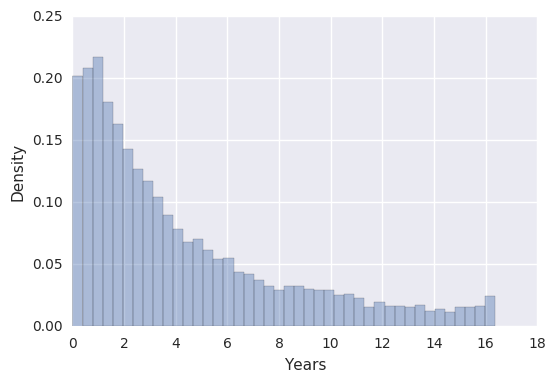

In [355]:
activity = investors_investments.groupby('investor_uuid').on.apply(lambda x: (x.max() - x.min()).days)
activity = activity[activity != 0] / 365 # neglect one-time investors

sn.distplot(activity, kde=False, norm_hist=True)
plt.xlabel('Years')
plt.ylabel('Density')
plt.savefig('investments_by_years.png')

Observing the plot, activity's half-life is about **3 years**. This means that *the average investor gathers and invests its entire capital in that time*. 

When calculating the investor influence, only the last 3 years of investors’ actions are considered. This way influence does not accumulate forever but increases or decreases in time.

Time segments are disposed in quarters—in other words we take 3-year snapshots of investment data each 3 months.

In [671]:
from datetime import datetime

# generate quarters
dates = [datetime(year, month, 1) for year in range(LEAST_RECENT_DATA_SET_DATE.year, MOST_RECENT_DATA_SET_DATE.year + 1) \
         for month in (1,4,7,10) if year < MOST_RECENT_DATA_SET_DATE.year or month < MOST_RECENT_DATA_SET_DATE.month]

# generate 3-year segments (12-quarter segments) rolling on quarters
time_segments = zip(dates, dates[12:])

### Computation of features

In [672]:
investor_features = pd.DataFrame()

for date_from, date_to in time_segments:
    time_segmented_investments = investors_investments[investors_investments.on.between(date_from, date_to, inclusive=False)]
    
    # FEATURES
    
    # aggregation by investor
    features = time_segmented_investments.groupby('investor_uuid', sort=False).agg({
        'company_uuid':'nunique',
        'funding_round_type':'count',
        'funding_round_code':'count',
        'is_lead_investor':'sum',
        'return':'sum',
        'loss':'sum',
        'amount':'sum'
    })

    # column renaming to more meaningful names
    features.rename(columns={
        'company_uuid':'investor_companies',
        'funding_round_type':'investor_rounds',
        'funding_round_code':'investor_venture_rounds',
        'is_lead_investor':'investor_leads',
        'return':'investor_returns',
        'loss':'investor_losses',
        'amount':'investor_amount'
    }, inplace=True)

    # SOCIAL NETWORK ANALYSIS
    
    G = investors_graph(time_segmented_investments)
    features['investor_score'] = pd.Series( nx.katz_centrality(G, weight='weight', alpha=0.001) )
    features.fillna(0, inplace=True)
    features['investor_rank']  = features.investor_score.rank(ascending=False)
    
    features['from']  = date_from
    features['to']    = date_to
    investor_features = investor_features.append(features)

Persist investor features and the most recent investor network.

In [673]:
investor_features.to_csv('investor_features.csv')

recent = investor_features[investor_features.to == date_to]

recent = pd.DataFrame.merge(investors, recent, left_index=True, right_index=True, how='inner') \
           .sort_values(by='investor_rank').drop(['from', 'to'], axis=1)

recent.to_csv('investor_influence_graph_metadata_%s.csv' % date_to.strftime('%Y-%m-%d'))

nx.write_gpickle(G, 'investor_influence_graph_%s.pickle' % date_to.strftime('%Y-%m-%d'))